### DT classifier with RFE feature selection method

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import roc_curve, auc
import joblib
from plot_metrics import *

In [2]:
def DT_best_params(X,y, params):
    #Train and valid split
    X_train,X_val,y_train,y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
   #Model Fitting
    clf = DecisionTreeClassifier(**params)
    y_train = y_train.values.ravel()
    clf.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = clf.predict(X_val)
    
    #Probability estimates
    pred_probs = clf.predict_proba(X_val)
    probs_isgoal = pred_probs[:,1]
    
    #Model Evaultion Metrics
    accuracy = metrics.accuracy_score(y_val, y_pred)
    f1_score = metrics.f1_score(y_val, y_pred)
    precision = metrics.precision_score(y_val, y_pred)
    recall = metrics.recall_score(y_val, y_pred)
    cf_matrix = metrics.confusion_matrix(y_val,y_pred)
    roc_auc = metrics.roc_auc_score(y_val,probs_isgoal)
    
    #ROC AUC Curve
    plot_ROC(y_val, pred_probs)
        
    #Goal Rate Plot
    df_percentile =  calc_percentile(pred_probs, y_val)
    goal_rate_df = goal_rate(df_percentile)
    plot_goal_rates(goal_rate_df)
        
    #Cumulative Goal Rate Plot
    plot_cumulative_goal_rates(df_percentile)
        
    #Calibration Curve
    plot_calibration_curve_prediction(y_val, pred_probs)   
    
        
    return pred_probs, accuracy,f1_score, precision, recall, roc_auc, cf_matrix

In [3]:
# Read in data and assign X and y
data = pd.read_csv('../../../data/train.csv', index_col=0)
X = data[data.columns.tolist()[:-1]]
y = data[['isGoal']]
X

,time,period,coordinateX,coordinateY,shotDistance,shotAngle,shotType,emptyNet,lastEventType,lastCoordinateX,lastCoordinateY,lastTime,lastShotDistance,rebound,changeShotAngle,speed,friendlyPlayersOnIce,opposingPlayersOnIce,timeSincePP
gameId,,,,,,,,,,,,,,,,,,,
2015020001,51,1,-55.0,6.0,34.5254,10.0080,6,0,5,94.0,-34.0,11,154.2757,0,0.0000,14.0251,5,5,0
2015020001,65,1,-79.0,0.0,10.0000,0.0000,3,0,3,-37.0,-28.0,7,50.4777,0,0.0000,7.2111,5,5,0
2015020001,66,1,-75.0,-1.0,14.0357,-4.0856,3,0,14,-79.0,0.0,1,4.1231,1,-4.0856,4.1231,5,5,0
2015020001,113,1,-55.0,-36.0,49.5177,-46.6366,6,0,5,-91.0,35.0,18,79.6053,0,0.0000,4.4225,5,5,0
2015020001,157,1,-61.0,-1.0,28.0179,-2.0454,4,0,1,-69.0,-22.0,5,22.4722,0,0.0000,4.4944,5,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018021271,3337,3,67.0,-19.0,29.0689,-40.8151,2,0,3,29.0,35.0,33,66.0303,0,0.0000,2.0009,5,5,0
2018021271,3393,3,-78.0,1.0,11.0454,5.1944,6,0,1,-69.0,-22.0,29,24.6982,0,0.0000,0.8517,5,5,0
2018021271,3519,3,-82.0,10.0,12.2066,55.0080,6,0,6,-71.0,4.0,19,12.5300,0,0.0000,0.6595,5,5,0


### Feature Selection: Recursive feature elimination

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

col_list = X.columns.to_list()
feature_names = np.array(X.columns.to_list())
print("Feature Names:", feature_names)


X = X.copy()
tot_col = len(X.columns)

y_flatten = y.values.ravel()

model = RandomForestClassifier()


rfe = RFE(model, n_features_to_select=15)
fit = rfe.fit(X, y_flatten)

print("Num Features: ", fit.n_features_)
#print("Selected Features Mask: ", fit.support_)
#print("Feature Ranking: ", fit.ranking_)

selected_features = feature_names[fit.support_]
#Selected feature names
print('Selected feature names: ', selected_features)

features_dropped = set(col_list).difference(selected_features)
print('features_dropped: ', features_dropped)

Feature Names: ['time' 'period' 'coordinateX' 'coordinateY' 'shotDistance' 'shotAngle'
 'shotType' 'emptyNet' 'lastEventType' 'lastCoordinateX' 'lastCoordinateY'
 'lastTime' 'lastShotDistance' 'rebound' 'changeShotAngle' 'speed'
 'friendlyPlayersOnIce' 'opposingPlayersOnIce' 'timeSincePP']
Num Features:  15
Selected feature names:  ['time' 'period' 'coordinateX' 'coordinateY' 'shotDistance' 'shotAngle'
 'shotType' 'emptyNet' 'lastEventType' 'lastCoordinateX' 'lastCoordinateY'
 'lastTime' 'lastShotDistance' 'changeShotAngle' 'speed']
features_dropped:  {'timeSincePP', 'friendlyPlayersOnIce', 'rebound', 'opposingPlayersOnIce'}


In [5]:
X_new = X[selected_features]
print('Shape of new X', X_new.shape)

Shape of new X (315532, 15)


### Loading the the best  model from gridsearch for DT classifier

In [6]:
dt_grid_search_model = joblib.load("../dt_random_best_model.pkl")
dt_best_params = dt_grid_search_model.best_params_
dt_best_params

{'splitter': 'best',
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 10,
 'criterion': 'gini'}

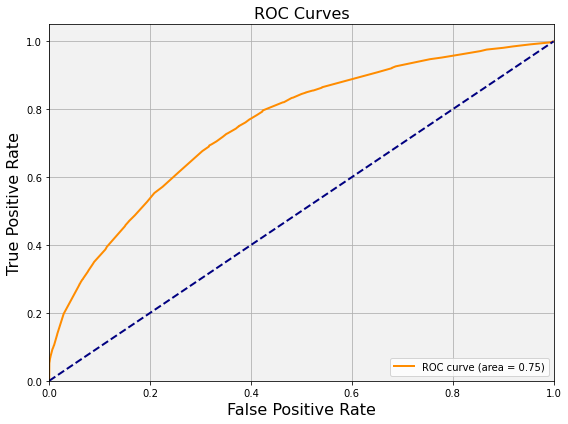

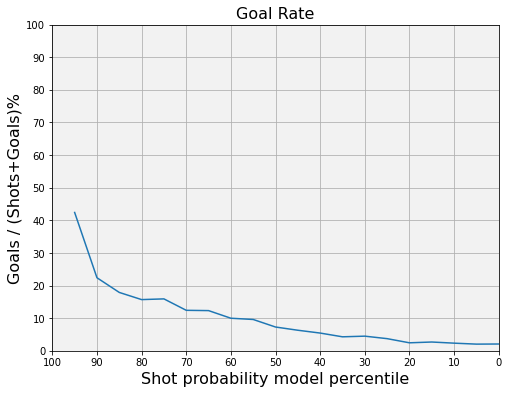

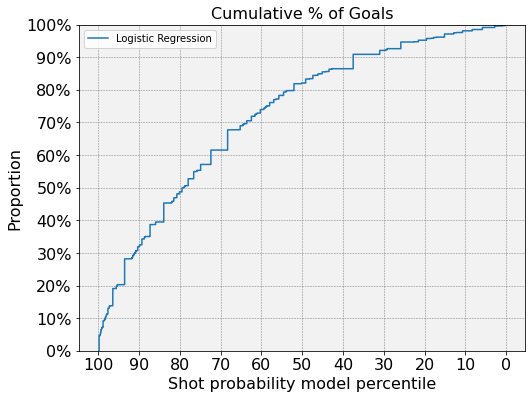

<Figure size 576x432 with 0 Axes>

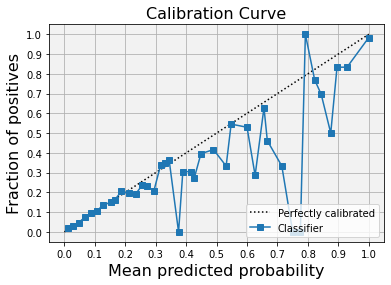

 accuracy: 0.9047173847592185
 f1_score: 0.12639837280255703
 precision: 0.7823741007194245
 recall: 0.0687529634898056
 roc_auc: 0.7521398477137154
[[56659   121]
 [ 5892   435]]


In [7]:
pred_probs, accuracy,f1_score, precision, recall, roc_auc, cf_matrix = DT_best_params(X_new, y, dt_best_params)
print(f' accuracy: {accuracy}')
print(f' f1_score: {f1_score}')
print(f' precision: {precision}')
print(f' recall: {recall}')
print(f' roc_auc: {roc_auc}')
print(cf_matrix)

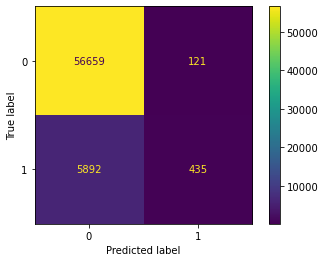

In [8]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
disp.plot()